In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_predict,cross_val_score,RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
#rom catboost import CatBoostClassifier
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_curve, roc_auc_score, auc
from sklearn.feature_extraction.text import TfidfVectorizer

import re
import gensim

import warnings
import matplotlib.pyplot as plt

%matplotlib inline
warnings.simplefilter('ignore')

In [ ]:
data_wo = pd.read_csv("clean_data_without_some.csv")
print('shape of limited data without text variable:', data_wo.shape) #12365,12
data_with = pd.read_csv("clean_data.csv")
print('shape of whole data:', data_with.shape) #12365, 24

shape of limited data without text variable: (12365, 12)
shape of whole data: (12365, 24)


In [ ]:
data_with.columns

Index(['id', 'created_at', 'user_created_at', 'lang', 'source', 'text',
       'user_description', 'user_location', 'hashtags', 'clean text',
       'clean text without stem', 'source_5', 'favorite_count',
       'retweet_count', 'user_id', 'user_favourites_count',
       'user_followers_count', 'user_friends_count', 'user_listed_count',
       'user_statuses_count', 'user_verified', 'is_misinfo', 'polarity',
       'subjectivity'],
      dtype='object')

In [ ]:
data_with = data_with[['favorite_count', 'retweet_count',  'user_favourites_count',
       'user_followers_count', 'user_friends_count', 'user_listed_count',
       'user_statuses_count', 'user_verified', 'is_misinfo', 'polarity',
       'subjectivity','text']]

In [ ]:
data_with.columns

Index(['favorite_count', 'retweet_count', 'user_favourites_count',
       'user_followers_count', 'user_friends_count', 'user_listed_count',
       'user_statuses_count', 'user_verified', 'is_misinfo', 'polarity',
       'subjectivity', 'text'],
      dtype='object')

In [ ]:
data_wo.columns

Index(['favorite_count', 'retweet_count', 'user_id', 'user_favourites_count',
       'user_followers_count', 'user_friends_count', 'user_listed_count',
       'user_statuses_count', 'user_verified', 'is_misinfo', 'polarity',
       'subjectivity'],
      dtype='object')

In [ ]:
data_wo = data_wo[['favorite_count', 'retweet_count',  'user_favourites_count',
       'user_followers_count', 'user_friends_count', 'user_listed_count',
       'user_statuses_count', 'user_verified', 'is_misinfo', 'polarity',
       'subjectivity']]

In [ ]:
# id should be index
#data_with.set_index('id')

KeyError: ignored

TO-DO: scaler should conduct seperately at train and test sets https://towardsdatascience.com/using-machine-learning-to-predict-fitbit-sleep-scores-496a7d9ec48

# Basline Model with Limited Data
random forest

In [ ]:
x_variable_wo = data_wo.columns[~(data_wo.columns.isin(['is_misinfo']))]                                         

In [ ]:
# https://stackoverflow.com/questions/46598301/how-to-compute-precision-recall-and-f1-score-of-an-imbalanced-dataset-for-k-fold
# https://towardsdatascience.com/cross-testation-and-hyperparameter-tuning-how-to-optimise-your-machine-learning-model-13f005af9d7d
x = data_wo[x_variable_wo].values
y = data_wo['is_misinfo'].values

# train/test = 80/20
x_train, x_test, y_train, y_test = train_test_split(
    x,
    y,
    test_size=0.2,
    random_state = 0
    )  

scoring = {'accuracy': make_scorer(accuracy_score),
           'precision': make_scorer(precision_score),
           'recall': make_scorer(recall_score),
           'f1_score': make_scorer(f1_score),
           'auc': 'roc_auc'}

# Interesting: sensitivity analysis of k in kfold https://machinelearningmastery.com/how-to-configure-k-fold-cross-validation/

In [ ]:
x_variable_wo

Index(['favorite_count', 'retweet_count', 'user_favourites_count',
       'user_followers_count', 'user_friends_count', 'user_listed_count',
       'user_statuses_count', 'user_verified', 'polarity', 'subjectivity'],
      dtype='object')

In [ ]:
# https://stats.stackexchange.com/questions/123124/how-to-determine-the-optimal-threshold-for-a-classifier-and-generate-roc-curve
def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:,1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy at threshold of 0.5: {accuracy*100:.2f}%')
    
    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = threshold[optimal_idx]
    print("The optimal threshold value is:", optimal_threshold)
    plt.show()

## Random Forest

In [ ]:
# tuning hyperpameter: https://github.com/WillKoehrsen/Machine-Learning-Projects/blob/master/random_forest_explained/Improving%20Random%20Forest%20Part%202.ipynb
# hyperparameter grid
# number of trees in RF
rf_n_estimators = [int(x) for x in np.linspace(200, 500, 100)]

#maximum number of levels in tree
rf_max_depth = [int(x) for x in np.linspace(10, 50, 10)]

# criterion to split on
rf_criterion = ['gini', 'entropy']

# method of selecting samples for training each tree
rf_bootstrap = [True, False]

# final grid
rf_grid = {'n_estimators': rf_n_estimators,
           'max_depth': rf_max_depth,
           'criterion': rf_criterion,
           'bootstrap': rf_bootstrap}

In [ ]:
# feature importance: https://stackoverflow.com/questions/55466081/how-to-calculate-feature-importance-in-each-models-of-cross-validation-in-sklear
rfc = RandomForestClassifier(random_state=0)

rf = RandomizedSearchCV(estimator=rfc, param_distributions=rf_grid, scoring=make_scorer(f1_score), 
                        n_iter=10, cv=3,random_state=0, return_train_score=True)

rf.fit(x_train, y_train)

# view the best parameters from random search
print(rf.best_params_)
print(rf.best_score_) # F1 score
print(rf.best_estimator_)

{'n_estimators': 393, 'max_depth': 18, 'criterion': 'entropy', 'bootstrap': False}
0.6594999203694855
RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=18,
                       n_estimators=393, random_state=0)


AUC: 1.0000
Accuracy at threshold of 0.5: 99.65%
The optimal threshold value is: 0.4750936670899316


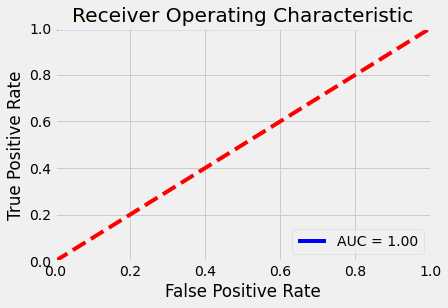

AUC: 0.8581
Accuracy at threshold of 0.5: 79.82%
The optimal threshold value is: 0.45292579826866014


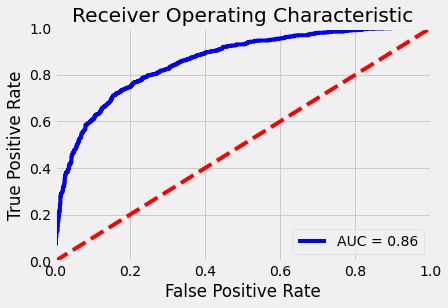

In [ ]:
# training ROC
train_pred = rf.best_estimator_.predict_proba(x_train)
evaluate_roc(train_pred, y_train)

# test ROC
test_pred = rf.best_estimator_.predict_proba(x_test)
evaluate_roc(test_pred, y_test)

In [ ]:
# https://github.com/WillKoehrsen/Machine-Learning-Projects/blob/master/random_forest_explained/Improving%20Random%20Forest%20Part%201.ipynb
# Get numerical feature importances
importances = list(rf.best_estimator_.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(x_variable_wo, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: favorite_count       Importance: 0.14
Variable: user_friends_count   Importance: 0.13
Variable: user_statuses_count  Importance: 0.13
Variable: user_favourites_count Importance: 0.12
Variable: polarity             Importance: 0.12
Variable: user_followers_count Importance: 0.11
Variable: subjectivity         Importance: 0.11
Variable: user_listed_count    Importance: 0.08
Variable: retweet_count        Importance: 0.06
Variable: user_verified        Importance: 0.01


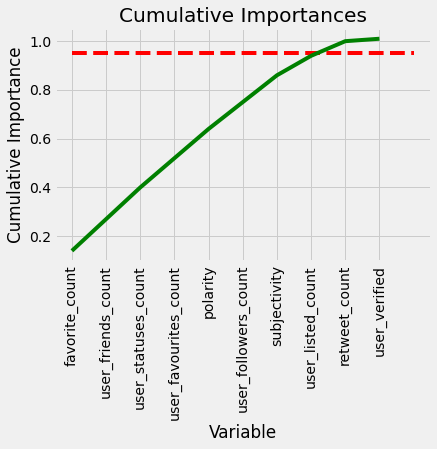

In [ ]:
# Reset style 
plt.style.use('fivethirtyeight')

# list of x locations for plotting
x_values = list(range(len(importances)))

# List of features sorted from most to least important
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]

# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)

# Make a line graph
plt.plot(x_values, cumulative_importances, 'g-')

# Draw line at 95% of importance retained
plt.hlines(y = 0.95, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')

# Format x ticks and labels
plt.xticks(x_values, sorted_features, rotation = 'vertical')

# Axis labels and title
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance'); plt.title('Cumulative Importances');

We only use the subjectivity and polarity of sentiment analysis of tweets. There might more useful content embeded in the raw tweets.

In [ ]:
data_wo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12365 entries, 0 to 12364
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   favorite_count         12365 non-null  float64
 1   retweet_count          12365 non-null  float64
 2   user_id                12365 non-null  float64
 3   user_favourites_count  12365 non-null  float64
 4   user_followers_count   12365 non-null  float64
 5   user_friends_count     12365 non-null  float64
 6   user_listed_count      12365 non-null  float64
 7   user_statuses_count    12365 non-null  float64
 8   user_verified          12365 non-null  float64
 9   is_misinfo             12365 non-null  float64
 10  polarity               12365 non-null  float64
 11  subjectivity           12365 non-null  float64
dtypes: float64(12)
memory usage: 1.1 MB


In [ ]:
'''cbf = CatBoostClassifier(
    iterations=10, 
    learning_rate=0.1, 
    verbose = 2
    #loss_function='CrossEntropy'
)

cat_feature = list(range(0, data_wo.shape[1]))

cbf.fit(
    x_train, y_train,
    cat_features=cat_feature,
    eval_set=(x_test, y_test),
)'''

"cbf = CatBoostClassifier(\n    iterations=10, \n    learning_rate=0.1, \n    verbose = 2\n    #loss_function='CrossEntropy'\n)\n\ncat_feature = list(range(0, data_wo.shape[1]))\n\ncbf.fit(\n    x_train, y_train,\n    cat_features=cat_feature,\n    eval_set=(x_valid, y_valid),\n)"

# Models with Text Data


## Discovery of other representations of free-text data

In [ ]:
data_with.head(3)

,favorite_count,retweet_count,user_favourites_count,user_followers_count,user_friends_count,user_listed_count,user_statuses_count,user_verified,is_misinfo,polarity,subjectivity,text
0,0.000036,0.0,0.006374,0.000021,0.001792,0.000190,0.004509,0.0,0.0,0.547500,0.590000,My 87 year old grandmother has been quarantini...
1,0.000018,0.0,0.001968,0.000005,0.000551,0.000023,0.002372,0.0,0.0,0.662500,0.575000,I’m so excited that with this vaccine I can se...
2,0.000027,0.0,0.017309,0.000011,0.001826,0.000153,0.003731,0.0,0.0,0.676847,0.563447,So excited that I was able to close out 2020 o...


In [ ]:
data_with.columns

Index(['favorite_count', 'retweet_count', 'user_favourites_count',
       'user_followers_count', 'user_friends_count', 'user_listed_count',
       'user_statuses_count', 'user_verified', 'is_misinfo', 'polarity',
       'subjectivity', 'text'],
      dtype='object')

In [ ]:
#data_with['source_5'].unique()

array(['Twitter for iPhone', 'Other Third Parties', 'Twitter for Android',
       'Twitter Web App', 'Twitter for iPad'], dtype=object)

In [ ]:
#print(data_with['hashtags'].nunique()) # 2477
#data_with['hashtags']

2447


0                       NaN
1            417fightscovid
2                       NaN
3               StandStrong
4                       NaN
                ...        
12360             CoronaVac
12361                   NaN
12362                   NaN
12363                   NaN
12364    unvaccinated Fauci
Name: hashtags, Length: 12365, dtype: object

In [ ]:
#interest_5 = data_with[['source_5','user_description','user_location', 'hashtags', 'clean text']]
#interest_5.isnull().sum() / interest_5.shape[0]

source_5            0.000000
user_description    0.090416
user_location       0.262030
hashtags            0.723332
clean text          0.000000
dtype: float64

In [ ]:
'''
# if not missing: assign 1; else assig 0 -> for 'user_description, user_location'
# hashtagss -> convert to number of it
data_with['user_description_bool'] = ''
data_with['user_description_bool'][data_with['user_description'].isnull() == True] = 0
data_with['user_description_bool'][data_with['user_description'].isnull() == False] = 1
data_with['user_location_bool'] = ''
data_with['user_location_bool'][data_with['user_location'].isnull() == True] = 0
data_with['user_location_bool'][data_with['user_location'].isnull() == False] = 1
'''

"\n# if not missing: assign 1; else assig 0 -> for 'user_description, user_location'\n# hashtagss -> convert to number of it\ndata_with['user_description_bool'] = ''\ndata_with['user_description_bool'][data_with['user_description'].isnull() == True] = 0\ndata_with['user_description_bool'][data_with['user_description'].isnull() == False] = 1\ndata_with['user_location_bool'] = ''\ndata_with['user_location_bool'][data_with['user_location'].isnull() == True] = 0\ndata_with['user_location_bool'][data_with['user_location'].isnull() == False] = 1\n"

In [ ]:
'''
data_with['hashtags_num'] = ''
for i in range(len(data_with['hashtags'])):
  if data_with['hashtags'].isnull()[i] == True:
    data_with['hashtags_num'][i] = 0 
  else:
    data_with['hashtags_num'][i] = data_with['hashtags'][i].count(' ') + 1
'''

"\ndata_with['hashtags_num'] = ''\nfor i in range(len(data_with['hashtags'])):\n  if data_with['hashtags'].isnull()[i] == True:\n    data_with['hashtags_num'][i] = 0 \n  else:\n    data_with['hashtags_num'][i] = data_with['hashtags'][i].count(' ') + 1\n"

In [ ]:
'''
data_with[['hashtags_num','user_description_bool', 'user_location_bool']]
'''

"\ndata_with[['hashtags_num','user_description_bool', 'user_location_bool']]\n"

In [ ]:
# convert source_5 into dummy variables
'''
source_5_dum = pd.get_dummies(data_with['source_5'])
data_with = pd.concat([data_with, source_5_dum], axis=1)
'''

"\nsource_5_dum = pd.get_dummies(data_with['source_5'])\ndata_with = pd.concat([data_with, source_5_dum], axis=1)\n"

In [ ]:
#data_with.columns

Index(['id', 'created_at', 'user_created_at', 'lang', 'source', 'text',
       'user_description', 'user_location', 'hashtags', 'clean text',
       'clean text without stem', 'source_5', 'favorite_count',
       'retweet_count', 'user_id', 'user_favourites_count',
       'user_followers_count', 'user_friends_count', 'user_listed_count',
       'user_statuses_count', 'user_verified', 'is_misinfo', 'polarity',
       'subjectivity'],
      dtype='object')

In [ ]:
'''
text_var = data_with[['hashtags_num',
       'Other Third Parties', 'Twitter Web App', 'Twitter for Android',
       'Twitter for iPad', 'Twitter for iPhone', ]]
'''

"\ntext_var = data_with[['hashtags_num',\n       'Other Third Parties', 'Twitter Web App', 'Twitter for Android',\n       'Twitter for iPad', 'Twitter for iPhone', ]]\n"

## Replicate AntiVax Paper 

### Random Forest with TF-IDF Embeddings

In [ ]:
set(data_with.columns) - set(data_wo.columns)

{'text'}

In [ ]:
x_variable_w = data_with.columns[~(data_with.columns.isin(['is_misinfo']))]                                            
  
x = data_with[x_variable_w].values
y = data_with['is_misinfo'].values 

# train/test = 80/20
x_train, x_test, y_train, y_test = train_test_split(
    x,
    y,
    test_size=0.2,
    random_state = 0
    )


x_train = pd.DataFrame(x_train)
x_train.set_index(0)
x_test = pd.DataFrame(x_test)
x_test.set_index(0)

,1,2,3,4,5,6,7,8,9,10
0,,,,,,,,,,
0.000009,0.0,0.00209,0.0,0.000037,0.0,0.000124,0.0,0.5,0.65,#Vaccinated with Dose 1 of @pfizer yesterday.\...
0.000018,0.0,0.001821,0.00004,0.000722,0.000065,0.000678,1.0,0.525,0.383333,The COVID vaccines work just like any other va...
0.000027,0.0,0.004906,0.000027,0.002307,0.000241,0.001638,0.0,0.5,0.0,"Daily goals: 1) lots of meetings today, set 2 ..."
0.000000,0.0,0.001965,0.000001,0.000359,0.0,0.00036,0.0,0.5,0.0,Lessons from history about a rushed vaccine ht...
0.000045,0.0,0.002762,0.000001,0.001001,0.000005,0.000497,0.0,0.441667,0.377778,My mother and I just got our first dose of the...
...,...,...,...,...,...,...,...,...,...,...
0.000232,0.0,0.040415,0.000069,0.00192,0.000232,0.019543,0.0,0.5,0.0,I AM ABOUT TO GET THE VACCINE
0.000000,0.0,0.001483,0.000002,0.000075,0.000005,0.001971,0.0,0.55,0.2,Was the Whole Pandemic About the Vaccine?\n\nC...
0.000000,0.0,0.011726,0.000029,0.001525,0.00007,0.013999,0.0,0.5,0.0,Bout to be zonked after this vaccine. I’m so t...


In [ ]:
x_variable_w

Index(['favorite_count', 'retweet_count', 'user_favourites_count',
       'user_followers_count', 'user_friends_count', 'user_listed_count',
       'user_statuses_count', 'user_verified', 'polarity', 'subjectivity',
       'text'],
      dtype='object')

In [ ]:
x_train[10]

0       if you’re doing an engineering degree, don’t w...
1       this 2nd vaccine dose will have u struggling f...
2       My aunt got the covid vaccine today because sh...
3       If you date men do not worry about what’s in t...
4                                  Hello vaccine day ❤️🇪🇺
                              ...                        
7414    My dad got the Moderna vaccine this morning an...
7415    just got the second dose of the mdrna vaccine....
7416    A comprehensive assessment of the #COVID19 #pa...
7417    #vaccinated #GetVaccinated #VaccinesWork \n\nN...
7418    I get my first dose of the vaccine today. Can’...
Name: 10, Length: 7419, dtype: object

#### NMF

In [ ]:
#https://predictivehacks.com/topic-modelling-with-nmf-in-python/
#https://medium.com/ml2vec/topic-modeling-is-an-unsupervised-learning-approach-to-clustering-documents-to-discover-topics-fdfbf30e27df
'''
from sklearn.decomposition import NMF
'''
#x_train_tfidf_norm.shape # too sparse need to extract key from features

'\nfrom sklearn.decomposition import NMF\n'

In [ ]:
# https://towardsdatascience.com/nmf-a-visual-explainer-and-python-implementation-7ecdd73491f8

'''
Here we will lemmatize all the words in the speeches so that different forms of 
a particular word will be reduced to a base form, for instance noun plurals 
become singular and all verb tenses become present. 
updated: also include verb
'''

import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer

# Noun extract and lemmatize function
def nouns(text):
    '''Given a string of text, tokenize the text 
    and pull out only the nouns.'''
    # create mask to isolate words that are nouns
    is_noun = lambda pos: pos[:2] == ('NN'or'VBP'or'vb')
    # store function to split string of words 
    # into a list of words (tokens)
    tokenized = word_tokenize(text)
    # store function to lemmatize each word
    wordnet_lemmatizer = WordNetLemmatizer()
    # use list comprehension to lemmatize all words 
    # and create a list of all nouns
    all_nouns = [wordnet_lemmatizer.lemmatize(word) \
    for (word, pos) in pos_tag(tokenized) if is_noun(pos)] 
    
    #return string of joined list of nouns
    return ' '.join(all_nouns)

# Create dataframe of only nouns from speeches
x_train['nouns_verbs'] = x_train[10].apply(nouns)
x_test['nouns_verbs'] = x_train[10].apply(nouns)

x_train.set_index(0)
x_test.set_index(0)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


,1,2,3,4,5,6,7,8,9,10,nouns_verbs
0,,,,,,,,,,,
0.000009,0.0,0.00209,0.0,0.000037,0.0,0.000124,0.0,0.5,0.65,#Vaccinated with Dose 1 of @pfizer yesterday.\...,engineering degree don ’ t worry ’ s vaccine
0.000018,0.0,0.001821,0.00004,0.000722,0.000065,0.000678,1.0,0.525,0.383333,The COVID vaccines work just like any other va...,vaccine dose life dude
0.000027,0.0,0.004906,0.000027,0.002307,0.000241,0.001638,0.0,0.5,0.0,"Daily goals: 1) lots of meetings today, set 2 ...",aunt covid vaccine today healthcare worker t h...
0.000000,0.0,0.001965,0.000001,0.000359,0.0,0.00036,0.0,0.5,0.0,Lessons from history about a rushed vaccine ht...,date men ’ s vaccine
0.000045,0.0,0.002762,0.000001,0.001001,0.000005,0.000497,0.0,0.441667,0.377778,My mother and I just got our first dose of the...,Hello vaccine day
...,...,...,...,...,...,...,...,...,...,...,...
0.000232,0.0,0.040415,0.000069,0.00192,0.000232,0.019543,0.0,0.5,0.0,I AM ABOUT TO GET THE VACCINE,vaccinatiepaspoort BLM BillGates DepopulationA...
0.000000,0.0,0.001483,0.000002,0.000075,0.000005,0.001971,0.0,0.55,0.2,Was the Whole Pandemic About the Vaccine?\n\nC...,✅ crohnsdisease http //t.co/lpoYNUxses
0.000000,0.0,0.011726,0.000029,0.001525,0.00007,0.013999,0.0,0.5,0.0,Bout to be zonked after this vaccine. I’m so t...,date people vaccine BC http //t.co/V2QtHBSVM0


In [ ]:
x_train.head(n=3)

,0,1,2,3,4,5,6,7,8,9,10,nouns_verbs
0,0.000018,0.0,0.001712,0.000001,0.000251,0.0,0.000175,0.0,0.5,0.0,"if you’re doing an engineering degree, don’t w...",engineering degree don ’ t worry ’ s vaccine
1,0.0,0.0,0.013296,0.0,0.000489,0.0,0.000203,0.0,0.5,0.0,this 2nd vaccine dose will have u struggling f...,vaccine dose life dude
2,0.000205,0.0,0.042499,0.000018,0.000933,0.000037,0.001256,0.0,0.779167,0.75,My aunt got the covid vaccine today because sh...,aunt covid vaccine today healthcare worker t h...


In [ ]:
# follow chunk copy from: https://www.kaggle.com/code/onadegibert/sentiment-analysis-with-tfidf-and-random-forest/notebook

def vectorize(data,tfidf_vect):
    #tfidf_vect = TfidfVectorizer(analyzer='word',stop_words='english', max_features=5000) # take top 5000 best features that can contribute to model
    X_tfidf = tfidf_vect.fit_transform(data)
    #words = tfidf_vect_fit.get_feature_names()
    X_tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns = tfidf_vect.get_feature_names())
    return(X_tfidf_df)

tfidf_vect = TfidfVectorizer(analyzer='word',stop_words='english', max_features=10, lowercase=False) # take top 5000 best features that can contribute to model
tfidf_vect_fit=tfidf_vect.fit(x_train['nouns_verbs'])
x_train_rf_tfidf_text=vectorize(x_train['nouns_verbs'],tfidf_vect_fit)


# test data
x_test_rf_tfidf_text=pd.DataFrame(tfidf_vect_fit.transform(x_test['nouns_verbs']).toarray())
# data leaky vs biased idf: https://stats.stackexchange.com/questions/154660/tfidfvectorizer-should-it-be-used-on-train-only-or-traintest#:~:text=Using%20TF%2DIDF,test%20set.

In [ ]:
x_train_rf_tfidf_text.head()

,COVID,Pfizer,Vaccine,amp,dose,http,people,shot,today,vaccine
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,1.000000
1,0.0,0.0,0.0,0.0,0.921961,0.0,0.0,0.0,0.00000,0.387282
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.93483,0.355097
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,1.000000
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,1.000000


In [ ]:
'''
def get_nmf_topics(model, n_top_words):
    
    #the word ids obtained need to be reverse-mapped to the words so we can print the topic names.
    feat_names = tfidf_vect.get_feature_names()
    
    word_dict = {};
    for i in range(10):
        
        #for each topic, obtain the largest values, and add the words they map to into the dictionary.
        words_ids = model.components_[i].argsort()[:-10 - 1:-1]
        words = [feat_names[key] for key in words_ids]
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = words;
    
    return pd.DataFrame(word_dict)
'''

In [ ]:
# create an NMF instance model
# the 10 components will be the topics
'''
nmf = NMF(n_components=10, random_state=0)

# fit the model
nmf.fit(x_train_rf_tfidf_text)
'''

In [ ]:
#get_nmf_topics(nmf, 10)

Qualitatively, we can conclude that the topics are quite different from each other and even attempt to give them a label for what theme they represent:

Topic 1: appointment
Topic 2: dont worry
Topic 3: today 
Topic 4: gene therapy
Topic 5: shot
Topic 6: people
Topic 7: pfizer
Topic 8: tomorrow
Topic 9: vaccines work
Topic 10: moderna

In [ ]:
#nmf.get_params

Combine
https://medium.com/towards-artificial-intelligence/topic-modeling-with-nmf-for-user-reviews-classification-65913d0b44fe

In [ ]:
# labeling the dataset with the topics
'''
We can now create an auxiliary table of topics labeled by their top 5 terms and 
our custom label, and use it to apply clustering to our dataset and label every 
document with its most representative topic.
'''
'''
def topic_table(n_top_words, feature_names, nmf):
  topics = {}
  for i, topic_vec in enumerate(nmf.components_):
    topic_descr = ''
    for fid in topic_vec.argsort()[-1:-n_top_words-1:-1]:
      topic_descr = topic_descr + feature_names[fid] + " "
    topics[i] = topic_descr
  return pd.DataFrame({'Top_Topic_Terms': topics})

# Label topics with top 5 terms
topic_df = topic_table(5, tfidf_vect.get_feature_names(), nmf)
# Manually label topics
topic_df['Label'] = ['appointment','dont worry', 'today','gene therapy', 'shot', 'issue', 'pfizer','tomorrow','vaccines work', 'moderna']
# Getting weights to classify our dataset
document_weights_train = nmf.transform(tfidf_vect.transform(x_train['nouns_verbs']))
document_weights_test = nmf.transform(tfidf_vect.transform(x_test['nouns_verbs']))
document_weights_test = nmf.transform(tfidf_vect.transform(x_test['nouns_verbs']))

# Store most representative topic
x_train["Topics"] = document_weights_train.argmax(axis=1)
x_test["Topics"] = document_weights_test.argmax(axis=1)

# Joining the original dataset with labels
x_train_temp = pd.merge(x_train, topic_df, left_on='Topics', right_index=True, how='left')
x_test_temp = pd.merge(x_test, topic_df, left_on='Topics', right_index=True, how='left')


x_train_final = x_train_temp.drop([0,1,'nouns_verbs','Top_Topic_Terms','Label'], axis=1)
x_test_final = x_test_temp.drop([0,1,'nouns_verbs','Top_Topic_Terms','Label'], axis=1)
'''

In [ ]:
#x_train.head()

In [ ]:
'''
rfc = RandomForestClassifier(random_state=0)

rf_with = RandomizedSearchCV(estimator=rfc, param_distributions=rf_grid, scoring=make_scorer(f1_score), 
                        n_iter=3, cv=5,random_state=0,verbose=2,return_train_score=True)

rf_with.fit(x_train_final, y_train)

# view the best parameters from random search
print(rf_with.best_params_)
print(rf_with.best_score_)
print(rf_with.best_estimator_)
'''

In [ ]:
# normalize
'''
column_mean = x_train['Topics'].mean()
column_std = x_train['Topics'].std()
column_min = min(x_train['Topics'])
column_max = max(x_train['Topics'])

x_train['Topics'] = (x_train['Topics'] - column_min) / (column_max - column_min)  
'''

In [ ]:
#x_train_final.head()

In [ ]:
'''
# training ROC
train_pred = rf_with.best_estimator_.predict_proba(x_train_final)
evaluate_roc(train_pred, y_train)

# test ROC
test_pred = rf_with.best_estimator_.predict_proba(x_test_final)
evaluate_roc(test_pred, y_test)

# ROC curve: https://stats.stackexchange.com/questions/263121/why-are-the-roc-curves-not-smooth#:~:text=know%20the%20question,model%20as%20such%3A
'''

To-DO: how to utilize the best threhold

https://stackoverflow.com/questions/62268459/accuracy-with-tf-idf-and-non-tf-idf-features

https://towardsdatascience.com/how-to-combine-textual-and-numerical-features-for-machine-learning-in-python-dc1526ca94d9

In [ ]:
'''
# https://github.com/WillKoehrsen/Machine-Learning-Projects/blob/master/random_forest_explained/Improving%20Random%20Forest%20Part%201.ipynb
# Get numerical feature importances
importances = list(rf_with.best_estimator_.feature_importances_)
x_variable_rf_with = ['favorite_count', 'retweet_count', 'user_favourites_count',
       'user_followers_count', 'user_friends_count', 'user_listed_count',
       'user_statuses_count', 'user_verified', 'polarity', 'subjectivity', 'Topics of Tweets']

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(x_variable_rf_with, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];
'''

In [ ]:
'''
# Reset style 
plt.style.use('fivethirtyeight')

# list of x locations for plotting
x_values = list(range(len(importances)))

# List of features sorted from most to least important
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]

# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)

# Make a line graph
plt.plot(x_values, cumulative_importances, 'g-')

# Draw line at 95% of importance retained
plt.hlines(y = 0.95, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')

# Format x ticks and labels
plt.xticks(x_values, sorted_features, rotation = 'vertical')

# Axis labels and title
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance'); plt.title('Cumulative Importances');
'''

In [ ]:
#rf_with.best_estimator_

#### Without NMF

In [ ]:
# Joining the original dataset with labels
x_train_temp = pd.merge(x_train, x_train_rf_tfidf_text,left_index=True, right_index=True, how='inner')
x_test_temp = pd.merge(x_test, x_test_rf_tfidf_text,left_index=True, right_index=True, how='inner')


x_train_final = x_train_temp.drop([10,'nouns_verbs'], axis=1)
x_test_final = x_test_temp.drop([10,'nouns_verbs'], axis=1)

In [ ]:
x_train_rf_tfidf_text.head(n=3)

,COVID,Pfizer,Vaccine,amp,dose,http,people,shot,today,vaccine
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,1.000000
1,0.0,0.0,0.0,0.0,0.921961,0.0,0.0,0.0,0.00000,0.387282
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.93483,0.355097


In [ ]:
x_train_final.head(n=3)

,0,1,2,3,4,5,6,7,8,9,COVID,Pfizer,Vaccine,amp,dose,http,people,shot,today,vaccine
0,0.000018,0.0,0.001712,0.000001,0.000251,0.0,0.000175,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,1.000000
1,0.0,0.0,0.013296,0.0,0.000489,0.0,0.000203,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.921961,0.0,0.0,0.0,0.00000,0.387282
2,0.000205,0.0,0.042499,0.000018,0.000933,0.000037,0.001256,0.0,0.779167,0.75,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.93483,0.355097


In [ ]:
x_test_final.head(n=3)

,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,0_y,1_y,2_y,3_y,4_y,5_y,6_y,7_y,8_y,9_y
0,0.000009,0.0,0.00209,0.0,0.000037,0.0,0.000124,0.0,0.5,0.65,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,1.000000
1,0.000018,0.0,0.001821,0.00004,0.000722,0.000065,0.000678,1.0,0.525,0.383333,0.0,0.0,0.0,0.0,0.921961,0.0,0.0,0.0,0.00000,0.387282
2,0.000027,0.0,0.004906,0.000027,0.002307,0.000241,0.001638,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.93483,0.355097


In [ ]:
rfc = RandomForestClassifier(random_state=0)

rf_with = RandomizedSearchCV(estimator=rfc, param_distributions=rf_grid, scoring=make_scorer(f1_score), 
                        n_iter=3, cv=5,random_state=0,verbose=2,return_train_score=True)

rf_with.fit(x_train_final, y_train)

# view the best parameters from random search
print(rf_with.best_params_)
print(rf_with.best_score_)
print(rf_with.best_estimator_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END bootstrap=False, criterion=gini, max_depth=41, n_estimators=296; total time=   4.1s
[CV] END bootstrap=False, criterion=gini, max_depth=41, n_estimators=296; total time=   4.0s
[CV] END bootstrap=False, criterion=gini, max_depth=41, n_estimators=296; total time=   4.1s
[CV] END bootstrap=False, criterion=gini, max_depth=41, n_estimators=296; total time=   4.1s
[CV] END bootstrap=False, criterion=gini, max_depth=41, n_estimators=296; total time=   4.1s
[CV] END bootstrap=False, criterion=gini, max_depth=36, n_estimators=221; total time=   3.0s
[CV] END bootstrap=False, criterion=gini, max_depth=36, n_estimators=221; total time=   3.0s
[CV] END bootstrap=False, criterion=gini, max_depth=36, n_estimators=221; total time=   3.0s
[CV] END bootstrap=False, criterion=gini, max_depth=36, n_estimators=221; total time=   3.1s
[CV] END bootstrap=False, criterion=gini, max_depth=36, n_estimators=221; total time=   3.0s
[CV] END b

In [ ]:
type(y_test)

numpy.ndarray

AUC: 1.0000
Accuracy at threshold of 0.5: 99.99%
The optimal threshold value is: 0.46984126984126984


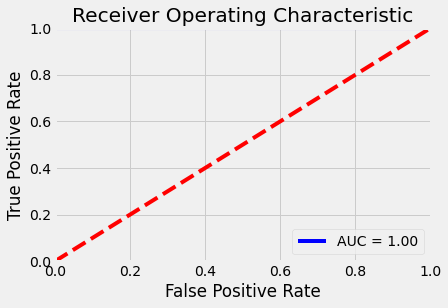

AUC: 0.7357
Accuracy at threshold of 0.5: 72.26%
The optimal threshold value is: 0.3780769230769231


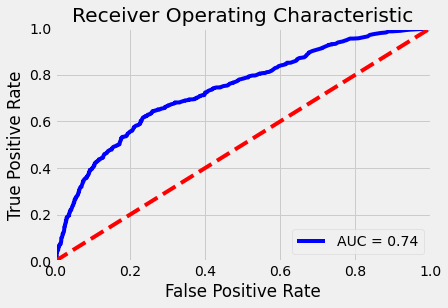

In [ ]:
# training ROC
train_pred = rf_with.best_estimator_.predict_proba(x_train_final)
evaluate_roc(train_pred, y_train)

# test ROC
test_pred = rf_with.best_estimator_.predict_proba(x_test_final)
evaluate_roc(test_pred, y_test)

# ROC curve: https://stats.stackexchange.com/questions/263121/why-are-the-roc-curves-not-smooth#:~:text=know%20the%20question,model%20as%20such%3A

In [ ]:
# https://github.com/WillKoehrsen/Machine-Learning-Projects/blob/master/random_forest_explained/Improving%20Random%20Forest%20Part%201.ipynb
# Get numerical feature importances
importances = list(rf_with.best_estimator_.feature_importances_)
x_variable_rf_with = ['favorite_count', 'retweet_count', 'user_favourites_count',
       'user_followers_count', 'user_friends_count', 'user_listed_count',
       'user_statuses_count', 'user_verified', 'polarity', 'subjectivity', 'TF-IDF Top1', 
       'TF-IDF Top2', 'TF-IDF Top3','TF-IDF Top4','TF-IDF Top5','TF-IDF Top6',
       'TF-IDF Top7','TF-IDF Top8','TF-IDF Top9', 'TF-IDF Top10']

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(x_variable_rf_with, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: favorite_count       Importance: 0.1
Variable: user_statuses_count  Importance: 0.1
Variable: user_favourites_count Importance: 0.09
Variable: user_followers_count Importance: 0.09
Variable: user_friends_count   Importance: 0.09
Variable: polarity             Importance: 0.09
Variable: subjectivity         Importance: 0.08
Variable: user_listed_count    Importance: 0.07
Variable: TF-IDF Top5          Importance: 0.05
Variable: TF-IDF Top6          Importance: 0.05
Variable: retweet_count        Importance: 0.04
Variable: TF-IDF Top9          Importance: 0.03
Variable: TF-IDF Top10         Importance: 0.03
Variable: TF-IDF Top3          Importance: 0.02
Variable: TF-IDF Top7          Importance: 0.02
Variable: user_verified        Importance: 0.01
Variable: TF-IDF Top1          Importance: 0.01
Variable: TF-IDF Top2          Importance: 0.01
Variable: TF-IDF Top4          Importance: 0.01
Variable: TF-IDF Top8          Importance: 0.01


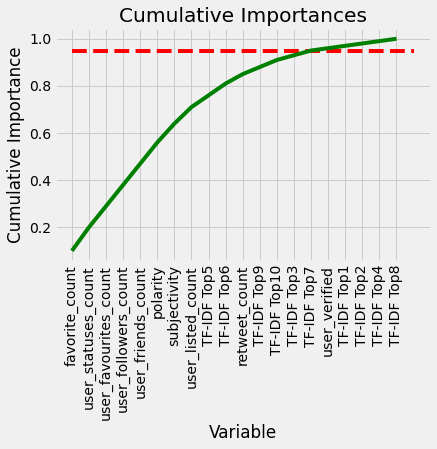

In [ ]:
# Reset style 
plt.style.use('fivethirtyeight')

# list of x locations for plotting
x_values = list(range(len(importances)))

# List of features sorted from most to least important
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]

# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)

# Make a line graph
plt.plot(x_values, cumulative_importances, 'g-')

# Draw line at 95% of importance retained
plt.hlines(y = 0.95, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')

# Format x ticks and labels
plt.xticks(x_values, sorted_features, rotation = 'vertical')

# Axis labels and title
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance'); plt.title('Cumulative Importances');

### LSTM model with Glove embedding
TO-DO: for deep learning model, those preprocessing shouldn't apply

### Transformer model using BERT
DistillBERT https://www.kaggle.com/code/georgesaavedra/best-sentiment-classifier-transformers/notebook https://towardsdatascience.com/hugging-face-transformers-fine-tuning-distilbert-for-binary-classification-tasks-490f1d192379
https://skimai.com/fine-tuning-bert-for-sentiment-analysis/

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 7.7 MB/s 
     |████████████████████████████████| 6.6 MB 48.9 MB/s 
     |████████████████████████████████| 596 kB 55.0 MB/s 
     |████████████████████████████████| 101 kB 10.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from transformers import BertTokenizer
import torch

In [ ]:
x_train.head(n=3)

,0,1,2,3,4,5,6,7,8,9,10,nouns_verbs
0,0.000018,0.0,0.001712,0.000001,0.000251,0.0,0.000175,0.0,0.5,0.0,"if you’re doing an engineering degree, don’t w...",engineering degree don ’ t worry ’ s vaccine
1,0.0,0.0,0.013296,0.0,0.000489,0.0,0.000203,0.0,0.5,0.0,this 2nd vaccine dose will have u struggling f...,vaccine dose life dude
2,0.000205,0.0,0.042499,0.000018,0.000933,0.000037,0.001256,0.0,0.779167,0.75,My aunt got the covid vaccine today because sh...,aunt covid vaccine today healthcare worker t h...


In [ ]:
x_train.drop(['nouns_verbs'], axis=1)

,0,1,2,3,4,5,6,7,8,9,10
0,0.000018,0.0,0.001712,0.000001,0.000251,0.0,0.000175,0.0,0.5,0.0,"if you’re doing an engineering degree, don’t w..."
1,0.0,0.0,0.013296,0.0,0.000489,0.0,0.000203,0.0,0.5,0.0,this 2nd vaccine dose will have u struggling f...
2,0.000205,0.0,0.042499,0.000018,0.000933,0.000037,0.001256,0.0,0.779167,0.75,My aunt got the covid vaccine today because sh...
3,0.003026,0.006414,0.001425,0.003013,0.000025,0.000181,0.0025,0.0,0.5,0.0,If you date men do not worry about what’s in t...
4,0.000116,0.0,0.004291,0.000097,0.001326,0.000644,0.001208,0.0,0.5,0.0,Hello vaccine day ❤️🇪🇺
...,...,...,...,...,...,...,...,...,...,...,...
7414,0.000018,0.0,0.004711,0.000014,0.002791,0.000125,0.000701,0.0,0.725,0.7,My dad got the Moderna vaccine this morning an...
7415,0.000152,0.000128,0.061789,0.000033,0.001849,0.000014,0.002452,0.0,0.5,0.0,just got the second dose of the mdrna vaccine....
7416,0.000009,0.000128,0.000092,0.000001,0.000743,0.0,0.000648,0.0,0.5,0.0,A comprehensive assessment of the #COVID19 #pa...
7417,0.0,0.0,0.651637,0.000104,0.01196,0.001084,0.169258,0.0,0.698864,0.477273,#vaccinated #GetVaccinated #VaccinesWork \n\nN...


TO-DO: only use text dataset, need to coperate them


In [ ]:
### --------- Setup DistilBERT ---------- ###

# Instantiate Distilbert tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Create a function to tokenize a set of texts
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data.values:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text = sent,
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

# before tokenizing, we need to specify the maximum length of sentences
# Encode our concatenated data
encoded_tweets = [tokenizer.encode(sent, add_special_tokens=True) for sent in x_train[10]]
# Find the maximum length
max_len = max([len(sent) for sent in encoded_tweets])
print('Max length: ', max_len)

Max length:  118


In [ ]:
# Apply tokenizer to dataset
MAX_LEN = 80

# Print sentence 0 and its encoded token ids
token_ids = list(preprocessing_for_bert(x_train[10]))
print('Original: ', x_train[1])
print('Token IDs: ', token_ids)

# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(x_train[10])
test_inputs, test_masks = preprocessing_for_bert(x_test[10])

# DATA SET CHANGE TO DATAFRAME

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Original:  0            0.0
1            0.0
2            0.0
3       0.006414
4            0.0
          ...   
7414         0.0
7415    0.000128
7416    0.000128
7417         0.0
7418    0.000128
Name: 1, Length: 7419, dtype: object
Token IDs:  [tensor([[  101,  2065,  2017,  ...,     0,     0,     0],
        [  101,  2023,  3416,  ...,     0,     0,     0],
        [  101,  2026,  5916,  ...,     0,     0,     0],
        ...,
        [  101,  1037,  7721,  ...,     0,     0,     0],
        [  101,  1001, 12436,  ...,     0,     0,     0],
        [  101,  1045,  2131,  ...,     0,     0,     0]]), tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])]
Tokenizing data...


In [ ]:
# create PyTorch DataLoader
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train).type(torch.LongTensor)
test_labels = torch.tensor(y_test).type(torch.LongTensor)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 32

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our test set
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [ ]:
# create BERT classifier
%%time
import torch
import torch.nn as nn
from transformers import BertModel

# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 2

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

CPU times: user 32.5 ms, sys: 7 µs, total: 32.5 ms
Wall time: 33.8 ms


In [ ]:
# optimizer & learning rate scheduler
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(epochs=4):
  """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
  """
  # Instantiate Bert Classifier
  bert_classifier = BertClassifier(freeze_bert=False)

  # Tell PyTorch to run the model on GPU
  bert_classifier.to(device)

  # Create the optimizer
  optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                    )
    
  #y_pred = np.where(preds >= 0.5, 1, 0)
  # Total number of training steps
  total_steps = len(train_dataloader) * epochs

  # Set up the learning rate scheduler
  scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
  return bert_classifier, optimizer, scheduler

In [ ]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla P100-PCIE-16GB


In [ ]:
# Train the model
import random
import time

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, test_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our testation set.
            test_loss, test_accuracy = evaluate(model, test_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {test_loss:^10.6f} | {test_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Training complete!")


def evaluate(model, test_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our testation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    test_accuracy = []
    test_loss = []

    # For each batch in our testation set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)
        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        test_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        test_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the testation set.
    test_loss = np.mean(test_loss)
    test_accuracy = np.mean(test_accuracy)

    return test_loss, test_accuracy

In [ ]:
set_seed(0)
bert_classifier, optimizer, scheduler = initialize_model(epochs=2)
train(bert_classifier, train_dataloader, test_dataloader, epochs=2, evaluation=True)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.444114   |     -      |     -     |   8.09   
   1    |   40    |   0.143546   |     -      |     -     |   5.35   
   1    |   60    |   0.142641   |     -      |     -     |   5.35   
   1    |   80    |   0.083589   |     -      |     -     |   5.35   
   1    |   100   |   0.089372   |     -      |     -     |   5.35   
   1    |   120   |   0.112175   |     -      |     -     |   5.35   
   1    |   140   |   0.103605   |     -      |     -     |   5.35   
   1    |   160   |   0.070613   |     -      |     -     |   5.35   
   1    |   180   |   0.075100   |     -      |     -     |   5.35   
   1    |   200   |   0.066081   |     -      |     -     |   5.35   
   1    |   220   |   0.053345   |     -      |     -     |   5.35   
   1    |   231   |   0.052262   |     -      |     -     |   2.89   


In [ ]:
torch.save(bert_classifier.state_dict(),'/content/bert_classifer0817.pth') 

In [ ]:
# Evaluate on validation set
import torch.nn.functional as F

def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

AUC: 0.9975
Accuracy at threshold of 0.5: 98.38%
The optimal threshold value is: 0.018117584


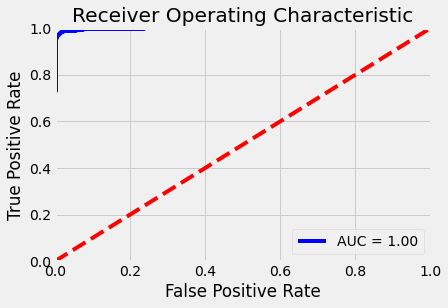

0.9759615384615385

In [ ]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, test_dataloader)

# Evaluate the Bert classifier
evaluate_roc(probs, y_test)

probs[:,1][probs[:,1]>=0.5] = 1
probs[:,1][probs[:,1]<0.5] = 0
f1_score(probs[:,1], y_test)

In [ ]:
(probs[:,0] == probs[:,1]).any() == False


# why these models fall in some categories (differences)
# visualize (make you outstanding)(showcase)
## - test your hypothesis
## - github, platform
## plots (geo graph), directly 
#- show not only can run machine learning but also can show your visualization 
## not from binary classification point of view, from interesting questions view 

True

# Final Comparison

# Error Analysis

TO-DO: single script to run all the files (_main_)

In [ ]:
# cousera: error analysis
# Some error analysis done for you

#valid_pred = rf_with.best_estimator_.predict_proba(x_valid_final)
#evaluate_roc(valid_pred, y_valid)
#BERT model

print('Label Predicted Tweet')
theta = 0.10
for i in range(x_test.shape[0]):
  y_test_pred = np.where(probs[:,1] >= theta, 1, 0)
  #if np.abs(y_test[i] - y_test_pred[i]) > 0:
      #print('THE TWEET IS:', x_test[1][i], y_test[i])
  if y_test_pred[i] == 1 & y_test[i]!=0:
    print("THE MISLEADING TWEET (DETECT BY ALGO) IS:", x_test[1][i])

Label Predicted Tweet


TypeError: ignored

In [ ]:
# 1. timely detection tweets (but out of scope)2.location, time 3.ideally, it will be helpful to show one plot to show my conclusion 
# dashboard, world, us maps to click on state or city (geo target): time distribution 
# politic party related 
# if have robust geo tags, y: liberal vs republican ratio, x: time, color: ratio of misleading 
# apply to unseen data, show the library looks like, (see what it looks like in library)